In [1]:
########## Calling relevant libraries ##########
%matplotlib inline
import numpy as np
from sklearn.metrics import mean_squared_error
import scipy

# Setting matplotlib options for this notebook
import matplotlib
from matplotlib import pyplot as plt

import tensorflow as tf

import sklearn
from sklearn.externals import joblib

import neuravi

# Loading dataset

Dataset has been prepared before`

In [2]:
d = neuravi.Data("./data/")

# model with TensorFlow and Free Volume theory

The viscosity equation according to the Free Volume theory is:


$$log(\eta_{T}) = log(\eta_{0}) + \frac{2B}{T - T_0 + \sqrt((T-T_0)^2 +CT)}$$ 

In [3]:
d.X_train

array([[ 85.,   0.,  15.,   0., 915.],
       [ 85.,   0.,  15.,   0., 895.],
       [ 85.,   0.,  15.,   0., 875.],
       ...,
       [ 72.,   7.,   0.,  21., 891.],
       [ 72.,   7.,   0.,  21., 872.],
       [ 72.,   7.,   0.,  21., 852.]])

In [4]:
# we have the chemical composition as X train/valid/test, but also the temperature

chimie_train = d.X_train[:,0:4] # 14 if using all data, 4 if KNAS
temperature_train = d.X_train[:,4].reshape(-1,1)

chimie_valid = d.X_valid[:,0:4]
temperature_valid = d.X_valid[:,4].reshape(-1,1)

chimie_test = d.X_test[:,0:4]
temperature_test = d.X_test[:,4].reshape(-1,1)

# rescale chimie between 0 and 1

chimie_train = chimie_train/chimie_train.sum(axis=1).reshape(-1,1)
chimie_valid = chimie_valid/chimie_valid.sum(axis=1).reshape(-1,1)
chimie_test = chimie_test/chimie_test.sum(axis=1).reshape(-1,1)

We then create an object to create a network with 1 to 5 layers (ReLu activation units + dropout),

Following the reading of Kaufl, we will initiate the bias of the output neural net layer to values of parameters that are not far from reality.

Then results of output layer are used to calculate the parameters of the A-G equation (see above), which, in turn, gives the viscosity.

We use a L2 loss to determine distance from targets.

Optimizer is RMSprop, it seems the most stable from my test.

The code for the object is in the file neuravi.py

In [5]:
NIN = chimie_train.shape[1]
NHIDDEN = 100
NLAYER = 1
STDEV = 0.001
bias = np.array([-4.5,np.log(4000.),np.log(1000.),np.log(1.)])

mod = neuravi.Model_CG(NIN, num_layers=NLAYER,hidden_size=NHIDDEN, init_bias = bias)

We start a TF Interactive Session to initiate our model, and look at the initial predictions.

The idea is to avoid starting the training with an initial model very far from reality...

So we run this cell again and again until we see a relatively close correspondance.

Initial predictions should be in a -5 - 20 range... If not, too much iterations are required for proper convergence...

We just avoid values at 10^20....

OK, no interactive session running


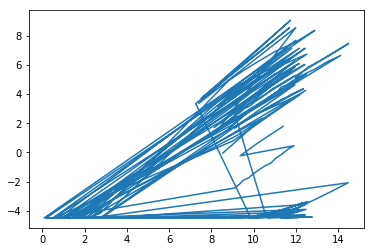

In [6]:
try:
    sess.close()
except:
    print("OK, no interactive session running")

sess = tf.InteractiveSession()
sess.run(mod.init_op)

pred_ini= sess.run(mod.visco_pred,feed_dict={mod.input_c: chimie_train, 
                                             mod.input_T: temperature_train, 
                                             mod.input_y: d.y_train.reshape(-1,1)})
plt.figure()
plt.plot(d.y_train, pred_ini)

We then train the network for 50,000 iterations. We use the full batch. Should not be a problem as our dataset is relatively small.

Convergence is slow.

I do not perform early stopping (lines are commented) as it does not bring anything to the training. It stops the training too early.

Furthermore, good validation and testing errors are in general obtained because we use dropout, which favour generalization.

In [7]:
NEPOCH = 10000
loss_train = np.zeros(NEPOCH) # store the training progress here.
loss_valid = np.zeros(NEPOCH) # store the training progress here.

early_stop = 1000 # not used below
count_es = 0

for i in range(NEPOCH):
    dct_train = {mod.prob: 1.0, mod.input_c: chimie_train, mod.input_T: temperature_train, mod.input_y: d.y_train.reshape(-1,1)}
    dct_valid = {mod.input_c: chimie_valid, mod.input_T: temperature_valid, mod.input_y: d.y_valid.reshape(-1,1)}
    
    sess.run(mod.optimizer,feed_dict=dct_train)
    loss_train[i] = sess.run(mod.loss, feed_dict=dct_train)
    loss_valid[i] = sess.run(mod.loss, feed_dict=dct_valid)
    
    if (i % 500 == 0):
            print("Batch train and valid loss at step {}: {}, {}".format(i, loss_train[i], loss_valid[i]))
    
    # implement early stopping
    if loss_valid[i]>loss_valid[i-1]:
        count_es += 1
        
    #if count_es > early_stop:
    #    break
        

Batch train and valid loss at step 0: 27148.06640625, 3955.51708984375
Batch train and valid loss at step 500: 12896.2685546875, 1392.640380859375
Batch train and valid loss at step 1000: 7222.509765625, 822.47265625
Batch train and valid loss at step 1500: 2167.802490234375, 281.84912109375
Batch train and valid loss at step 2000: 595.0847778320312, 70.871337890625
Batch train and valid loss at step 2500: 393.2823791503906, 34.12588882446289
Batch train and valid loss at step 3000: 344.9988708496094, 30.92635154724121
Batch train and valid loss at step 3500: 297.7032470703125, 31.456727981567383
Batch train and valid loss at step 4000: 255.0529327392578, 31.805057525634766
Batch train and valid loss at step 4500: 217.24127197265625, 33.320899963378906
Batch train and valid loss at step 5000: 188.54876708984375, 35.29827880859375
Batch train and valid loss at step 5500: 169.7657012939453, 37.0362548828125
Batch train and valid loss at step 6000: 157.4720916748047, 37.88290023803711
Bat

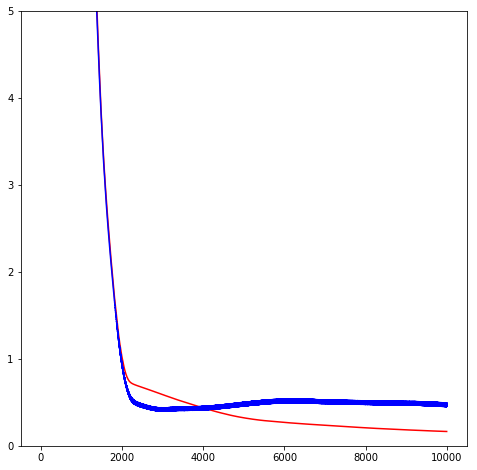

<Figure size 432x288 with 0 Axes>

In [8]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(0, NEPOCH,1), loss_train/d.X_train.shape[0], 'r-')
plt.plot(np.arange(0, NEPOCH,1), loss_valid/d.X_valid.shape[0], 'b-')
plt.ylim(0,5)
plt.show()
plt.savefig("epochs_cg.pdf")

Here this is supposed to save the model, which then can be re-used by tensorflow server...

In [9]:
name_out = "KNAS_CG_layer_"+str(NLAYER)+"units_"+str(NHIDDEN)+"it_"+str(NEPOCH)

tf.saved_model.simple_save(sess,
            "./model/"+name_out,
            inputs={"chimie": mod.input_c, "T": mod.input_T},
            outputs={"visco_pred": mod.visco_pred})

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./model/KNAS_CG_layer_1units_100it_10000/saved_model.pb


(-3, 15)

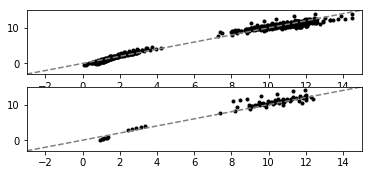

In [10]:
plt.figure()
plt.subplot(3,1,1)
plt.plot(d.y_train, sess.run(mod.visco_pred,feed_dict=dct_train),"k.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)

plt.subplot(3,1,2)
plt.plot(d.y_valid, sess.run(mod.visco_pred,feed_dict=dct_valid),"k.")

plt.plot([-3,15],[-3,15],"--",color="grey")

plt.xlim(-3,15)
plt.ylim(-3,15)